# Vanilla RNN, Country-Wide Daily Cases Data for Germany

RNN from first notebook in this folder had problem of saturating during the second wave, which saw much larger numbers than the first wave. To attempt to avoid this issue, I'm trying out the non-saturating activation function ReLU.

## Task and RNN Model

**Data**: Time-series for Germany from European Regional Tracker Dataset
- Time series $\mathbf{y} = [\mathbf{y}(1), \mathbf{y}(2), ..., \mathbf{y}(T)]^t$
- $\mathbf{y}(t) \in \mathbb{R}$ denotes  (normalized) number of new cases on $t$-th recorded day

**Model**: *Non-Autonomous* Vanilla RNN
- Equations: 
$$
\mathbf{h}(t+1) = \textrm{ReLU} \big( \mathbf{W}_{hh} \mathbf{h}(t) + \mathbf{W}_{yh} \textrm{SW}_\tau[y](t) + \mathbf{b}_h\big)
$$
$$
\mathbf{y}_{pred}(t) = \textrm{ReLU}\big(\mathbf{W}_{hy} \mathbf{h}(t) + b_y \big)
$$
- Trainable parameters:
    - Input-hidden weights $\mathbf{W}_{yh}$, a $N_h \times \tau$ matrix
    - Hidden-hidden weights $\mathbf{W}_{hh}$, a $N_h \times N_h$ matrix
    - Hidden-output weights $\mathbf{W}_{hy}$, a $1 \times N_h$ matrix
    - Hidden bias vector $\mathbf{b}_{h}$, a $N_h$-D Vector
    - Output bias vector $b_{y}$, a scalar
    - Initial Hidden State $\mathbf{h}(0)$, a $N_h$-D Vector
    
**Optimization Goal**: Train RNN such that $\mathbf{y}_{pred}$ close to $\mathbf{y}$

More specifically, we want to find $\mathbf{\Theta} = (\mathbf{W}_{hh}, \mathbf{W}_{yh}, \mathbf{W}_{hy}, \mathbf{b}_{h}, b_y, \mathbf{h}(0))$ that minimizes

$$
\textrm{RMSE}(\mathbf{y}, \mathbf{y}_{pred}) = \bigg[\frac{1}{T} \sum_{t=1}^T |\mathbf{y}(t) - \mathbf{y}_{pred}(t)|^2\bigg]^{1/2} 
$$


In [7]:
# Change root directory
import sys, os
sys.path.append(os.path.abspath('../../'))

In [9]:
# Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA

# MLP text size
import matplotlib
matplotlib.rc('font', size=16)

In [10]:
# Local Imports
from src.baseline_models import RNN
from src.load_data import ERT_germany
from src.train_and_eval import train
from src.clustering import hierarchical_clustering

## Parameters

In [41]:
# Dataset parameters
dtype = 'cases_daily'
t0 = 200 # Timestep to start the sequence
T = 150 # Sequence length
tau_minus = 5 # Sliding window size for inputs
tau_plus  = 1 # Slide window for outputs. Currently un-used
country_wide_total = True

# Model parameters
N_h = 64
p_hh = 1
g_hh = 1
f_h = 'relu'
f_out = 'relu'
sigma = 0e-3 # noise parameter
tau = 2
learn_tau = False

# Training parameters
n_epochs = 4 * 256
lr = 5e-4
lr_decay = 0.75
weight_decay = 0.0
batches_til_first_lr_update=2 * 256
clip_gradient_thres=None
verbose = True

## Setup

In [42]:
# Function to compute a sliding windows of the input time-series
def compute_SW(y, tau):
    """
    Given a tensor y of shape (T,), returns a new tensor SW
    of show (T,tau) where
    
                SW[t,k] =   0        if t-k < 0
                            y[t-k]   else
    """
    T = y.shape[0]
    SW = torch.zeros((T, tau))
    for i in range(tau):
        SW[(tau+1):,i] = y[:-(tau+1)]
    return SW

In [43]:
# Random Seed
seed = np.random.randint(1e6) # 349217
print('Random seed: %d' % seed)
np.random.seed(seed)

# Load the dataset
# directory where the data is stored, relative to this script
datadir = '../../euro_regional_tracker/germany_data/data'
# load the data from file
y_raw = ERT_germany(dtype=dtype, seq_len=T+t0, country_wide_total=country_wide_total,
    normalize=False, datadir=datadir
)[t0:]
# Save the sequence length
T = y_raw.shape[0]
# Create the input sequence (all zeros for now)
u = torch.zeros(1, T, 0)
# Reshape y_raw and save as the target y
y = y_raw.clone().view(1, T, 1)
y = y.view(1, T, 1)
# Normalize to -1,1
y -= y.min()
y /= 0.5 * y.max()
y -= 1

# Create the input sequence
SW = compute_SW(y.view(-1), tau_minus).view(1,-1,tau_minus)

# Create the RNN model
network = RNN(
    tau_minus, N_h, tau_plus,
    f_h=f_h, f_out=f_out, g_hh=g_hh, p_hh=p_hh,
    tau=tau, learn_tau=learn_tau
)

Random seed: 390390


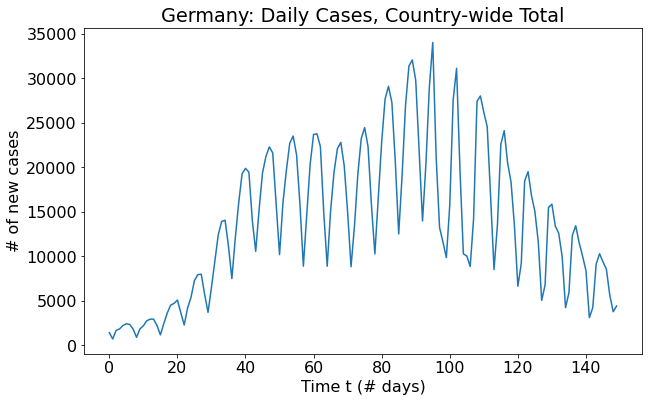

In [44]:
# Plot of what the raw data looks like
plt.figure(figsize=(10,6))
plt.title('Germany: Daily Cases, Country-wide Total')
plt.xlabel('Time t (# days)')
plt.ylabel('# of new cases')
plt.plot(y_raw)
plt.show()

## Training

In [45]:
losses, = train(network, SW, y, n_epochs, 1, lr, lr_decay=lr_decay,
        weight_decay=weight_decay,
        batches_til_first_lr_update=batches_til_first_lr_update,
        clip_gradient_thres=clip_gradient_thres, verbose=True
)

  Epoch 1/1024, Eval 1/1, Loss: 1.111
  Epoch 2/1024, Eval 1/1, Loss: 1.019
  Epoch 3/1024, Eval 1/1, Loss: 0.930
  Epoch 4/1024, Eval 1/1, Loss: 0.843
  Epoch 5/1024, Eval 1/1, Loss: 0.759
  Epoch 6/1024, Eval 1/1, Loss: 0.681
  Epoch 7/1024, Eval 1/1, Loss: 0.609
  Epoch 8/1024, Eval 1/1, Loss: 0.542
  Epoch 9/1024, Eval 1/1, Loss: 0.480
  Epoch 10/1024, Eval 1/1, Loss: 0.421
  Epoch 11/1024, Eval 1/1, Loss: 0.368
  Epoch 12/1024, Eval 1/1, Loss: 0.323
  Epoch 13/1024, Eval 1/1, Loss: 0.298
  Epoch 14/1024, Eval 1/1, Loss: 0.292
  Epoch 15/1024, Eval 1/1, Loss: 0.292
  Epoch 16/1024, Eval 1/1, Loss: 0.291
  Epoch 17/1024, Eval 1/1, Loss: 0.291
  Epoch 18/1024, Eval 1/1, Loss: 0.290
  Epoch 19/1024, Eval 1/1, Loss: 0.290
  Epoch 20/1024, Eval 1/1, Loss: 0.290
  Epoch 21/1024, Eval 1/1, Loss: 0.289
  Epoch 22/1024, Eval 1/1, Loss: 0.289
  Epoch 23/1024, Eval 1/1, Loss: 0.289
  Epoch 24/1024, Eval 1/1, Loss: 0.288
  Epoch 25/1024, Eval 1/1, Loss: 0.288
  Epoch 26/1024, Eval 1/1, Loss: 0

  Epoch 210/1024, Eval 1/1, Loss: 0.245
  Epoch 211/1024, Eval 1/1, Loss: 0.244
  Epoch 212/1024, Eval 1/1, Loss: 0.244
  Epoch 213/1024, Eval 1/1, Loss: 0.244
  Epoch 214/1024, Eval 1/1, Loss: 0.244
  Epoch 215/1024, Eval 1/1, Loss: 0.244
  Epoch 216/1024, Eval 1/1, Loss: 0.244
  Epoch 217/1024, Eval 1/1, Loss: 0.243
  Epoch 218/1024, Eval 1/1, Loss: 0.243
  Epoch 219/1024, Eval 1/1, Loss: 0.243
  Epoch 220/1024, Eval 1/1, Loss: 0.243
  Epoch 221/1024, Eval 1/1, Loss: 0.243
  Epoch 222/1024, Eval 1/1, Loss: 0.243
  Epoch 223/1024, Eval 1/1, Loss: 0.243
  Epoch 224/1024, Eval 1/1, Loss: 0.242
  Epoch 225/1024, Eval 1/1, Loss: 0.244
  Epoch 226/1024, Eval 1/1, Loss: 0.244
  Epoch 227/1024, Eval 1/1, Loss: 0.245
  Epoch 228/1024, Eval 1/1, Loss: 0.243
  Epoch 229/1024, Eval 1/1, Loss: 0.242
  Epoch 230/1024, Eval 1/1, Loss: 0.244
  Epoch 231/1024, Eval 1/1, Loss: 0.242
  Epoch 232/1024, Eval 1/1, Loss: 0.242
  Epoch 233/1024, Eval 1/1, Loss: 0.242
  Epoch 234/1024, Eval 1/1, Loss: 0.242


  Epoch 415/1024, Eval 1/1, Loss: 0.100
  Epoch 416/1024, Eval 1/1, Loss: 0.099
  Epoch 417/1024, Eval 1/1, Loss: 0.099
  Epoch 418/1024, Eval 1/1, Loss: 0.099
  Epoch 419/1024, Eval 1/1, Loss: 0.099
  Epoch 420/1024, Eval 1/1, Loss: 0.098
  Epoch 421/1024, Eval 1/1, Loss: 0.098
  Epoch 422/1024, Eval 1/1, Loss: 0.098
  Epoch 423/1024, Eval 1/1, Loss: 0.098
  Epoch 424/1024, Eval 1/1, Loss: 0.098
  Epoch 425/1024, Eval 1/1, Loss: 0.097
  Epoch 426/1024, Eval 1/1, Loss: 0.097
  Epoch 427/1024, Eval 1/1, Loss: 0.097
  Epoch 428/1024, Eval 1/1, Loss: 0.097
  Epoch 429/1024, Eval 1/1, Loss: 0.097
  Epoch 430/1024, Eval 1/1, Loss: 0.096
  Epoch 431/1024, Eval 1/1, Loss: 0.096
  Epoch 432/1024, Eval 1/1, Loss: 0.096
  Epoch 433/1024, Eval 1/1, Loss: 0.096
  Epoch 434/1024, Eval 1/1, Loss: 0.096
  Epoch 435/1024, Eval 1/1, Loss: 0.096
  Epoch 436/1024, Eval 1/1, Loss: 0.095
  Epoch 437/1024, Eval 1/1, Loss: 0.095
  Epoch 438/1024, Eval 1/1, Loss: 0.095
  Epoch 439/1024, Eval 1/1, Loss: 0.095


  Epoch 620/1024, Eval 1/1, Loss: 0.079
  Epoch 621/1024, Eval 1/1, Loss: 0.079
  Epoch 622/1024, Eval 1/1, Loss: 0.079
  Epoch 623/1024, Eval 1/1, Loss: 0.079
  Epoch 624/1024, Eval 1/1, Loss: 0.079
  Epoch 625/1024, Eval 1/1, Loss: 0.079
  Epoch 626/1024, Eval 1/1, Loss: 0.079
  Epoch 627/1024, Eval 1/1, Loss: 0.079
  Epoch 628/1024, Eval 1/1, Loss: 0.079
  Epoch 629/1024, Eval 1/1, Loss: 0.079
  Epoch 630/1024, Eval 1/1, Loss: 0.079
  Epoch 631/1024, Eval 1/1, Loss: 0.079
  Epoch 632/1024, Eval 1/1, Loss: 0.079
  Epoch 633/1024, Eval 1/1, Loss: 0.079
  Epoch 634/1024, Eval 1/1, Loss: 0.079
  Epoch 635/1024, Eval 1/1, Loss: 0.079
  Epoch 636/1024, Eval 1/1, Loss: 0.079
  Epoch 637/1024, Eval 1/1, Loss: 0.079
  Epoch 638/1024, Eval 1/1, Loss: 0.079
  Epoch 639/1024, Eval 1/1, Loss: 0.079
  Epoch 640/1024, Eval 1/1, Loss: 0.079
  Epoch 641/1024, Eval 1/1, Loss: 0.079
  Epoch 642/1024, Eval 1/1, Loss: 0.078
  Epoch 643/1024, Eval 1/1, Loss: 0.078
  Epoch 644/1024, Eval 1/1, Loss: 0.078


  Epoch 826/1024, Eval 1/1, Loss: 0.073
  Epoch 827/1024, Eval 1/1, Loss: 0.073
  Epoch 828/1024, Eval 1/1, Loss: 0.073
  Epoch 829/1024, Eval 1/1, Loss: 0.073
  Epoch 830/1024, Eval 1/1, Loss: 0.073
  Epoch 831/1024, Eval 1/1, Loss: 0.073
  Epoch 832/1024, Eval 1/1, Loss: 0.073
  Epoch 833/1024, Eval 1/1, Loss: 0.073
  Epoch 834/1024, Eval 1/1, Loss: 0.073
  Epoch 835/1024, Eval 1/1, Loss: 0.073
  Epoch 836/1024, Eval 1/1, Loss: 0.073
  Epoch 837/1024, Eval 1/1, Loss: 0.073
  Epoch 838/1024, Eval 1/1, Loss: 0.073
  Epoch 839/1024, Eval 1/1, Loss: 0.073
  Epoch 840/1024, Eval 1/1, Loss: 0.073
  Epoch 841/1024, Eval 1/1, Loss: 0.073
  Epoch 842/1024, Eval 1/1, Loss: 0.073
  Epoch 843/1024, Eval 1/1, Loss: 0.073
  Epoch 844/1024, Eval 1/1, Loss: 0.072
  Epoch 845/1024, Eval 1/1, Loss: 0.072
  Epoch 846/1024, Eval 1/1, Loss: 0.072
  Epoch 847/1024, Eval 1/1, Loss: 0.072
  Epoch 848/1024, Eval 1/1, Loss: 0.072
  Epoch 849/1024, Eval 1/1, Loss: 0.072
  Epoch 850/1024, Eval 1/1, Loss: 0.072


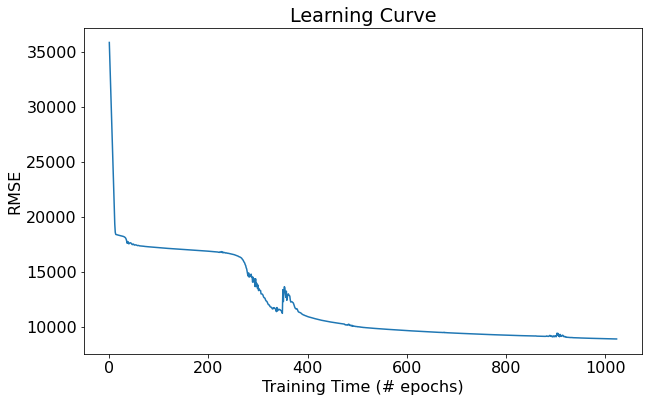

In [46]:
# Rescale losses to be in # of cases
rescaled_RMSE = y_raw.max() * np.sqrt(losses)

# Plot the learning curve
plt.figure(figsize=(10,6))
plt.title('Learning Curve')
plt.xlabel('Training Time (# epochs)')
plt.ylabel(r'RMSE')
plt.plot(rescaled_RMSE)
plt.show()

## Visualization

In [56]:
# Visualize predictions until user tells us otherwise
T_viz = 175 #int(4 * T)

# Target task for T=T_viz
y_viz = ERT_germany(dtype=dtype, seq_len=t0+T_viz, country_wide_total=country_wide_total,
    normalize=False, datadir=datadir
)[t0:]
# Normalize based on y_raw
y_viz_normalized = y_viz.clone()
y_viz_normalized /= 0.5 * y_raw.max()
y_viz_normalized -= 1
# Sliding window for input
SW_viz = compute_SW(y_viz_normalized, tau_minus).view(1,-1,tau_minus)


# Make a prediction
with torch.no_grad():
    hd, y_pred = network(SW_viz, return_dynamics=True)

# Reshape and normalize
H = hd.detach().numpy().reshape(-1, N_h)
# H = (H - np.mean(H, axis=0)) # / np.std(H, axis=0)


# Reshape y_pred
y_pred = y_pred.view(T_viz)

# Re-scale y_pred to be in units of # of cases
y_pred = (1 + y_pred) * y_raw.max() * 0.5

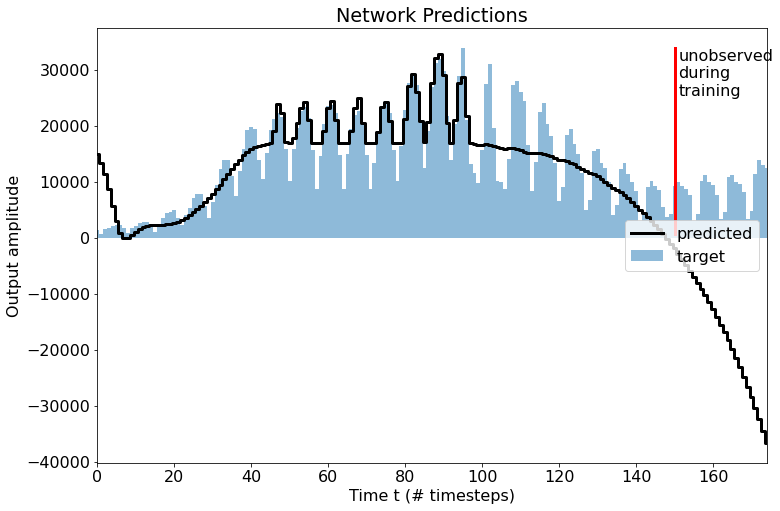

In [57]:
"""
Visualize predictions
"""
plt.figure(figsize=(12,8))
plt.title('Network Predictions')
plt.xlabel('Time t (# timesteps)')
plt.ylabel('Output amplitude')
plt.xlim(0,T_viz-1)
# Plot output target
plt.fill_between(
    np.arange(T_viz), y_viz,
    step='mid', alpha=0.5,
    label='target'
)
# Plot network prediction
plt.plot(
    np.arange(T_viz), y_pred,
    ds='steps-mid', c='k', linewidth=3,
    label='predicted'
)
plt.legend(loc='center right')
# Add a line to indicate data the network saw during training
plt.plot([T,T],[y_viz.min(), y_viz.max()], 'r', linewidth=3)
plt.text(T + 1, y_viz.max() * 0.75, 'unobserved\nduring\ntraining')
plt.show()

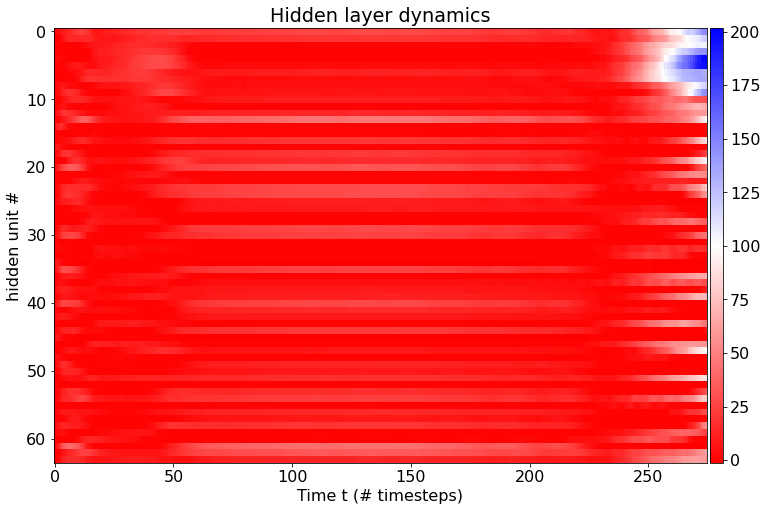

In [31]:
"""
Dynamics heatmap
"""

# Reshape and normalize
H = hd.detach().numpy().reshape(-1, N_h)
H_centered = (H - np.mean(H, axis=0)) # / np.std(H, axis=0)

# Clustering
order = hierarchical_clustering(H_centered)

# Reorder dynamics heatmap
h_viz = np.zeros_like(H.T)
# Reorder columns of h
for j in range(N_h):
    h_viz[j] = H[:,order[j]]

plt.figure(figsize=(12,8))
plt.title('Hidden layer dynamics')
plt.xlabel('Time t (# timesteps)')
plt.ylabel('hidden unit #')
vmxx = np.max(np.abs(h_viz))
im = plt.imshow(h_viz, aspect='auto', interpolation='none', cmap='bwr_r'
)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

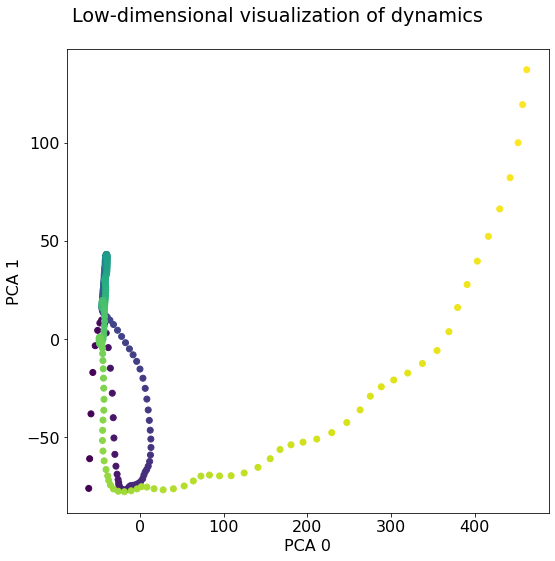

In [25]:
"""
PCA of Dynamics
"""

fig, ax = plt.subplots(1,1,figsize=(8,8))
fig.suptitle('Low-dimensional visualization of dynamics')

# Subplot 1: PCA
pca = PCA(n_components=5)
H_pca = pca.fit_transform(h_viz.T)

PCA_inds = [0,1]
ax.set_xlabel('PCA %d' % PCA_inds[0])
ax.set_ylabel('PCA %d' % PCA_inds[1])
ax.scatter(
    H_pca[:, PCA_inds[0]],
    H_pca[:, PCA_inds[1]],
    c=np.arange(T_viz)/T_viz
)

plt.tight_layout()
plt.show()

## Potential Ideas

- Transfer learning (idea from Carl)
  - Train on data from the flu
  - See if this known is sufficient to see how covid evolves
- Train up to first half of second wave, so how well RNN does testing on second half of second wave 
- Use smaller RNN to see how few params we need to get good output
- Also, actually get the RNN input